In [756]:
## IMPORT RELEVANT DICTIONARIES AND MODULES
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm 
import scipy.stats as sts
from scipy.stats import t
from scipy.stats import lognorm

In [757]:
## PARAMS FOR REDUCED RATE MODEL
V_rest = -70.0 # mV, resting membrane potential

tau_E = 20.0 # ms, E neuron time constant 
tau_I = 10.0 # ms, I neuron time constant
tau = [tau_E, tau_I]

W_EE = 1.25 # mV*s, connection weight 
W_IE = 1.2 # mV*s, connection weight
W_EI = 0.65 # mV*s, connection weight
W_II = 0.5 # mV*s, connection weight
W = np.array([[W_EE, -W_EI],
            [W_IE, -W_II]])

b = 2.0 # mV, input baseline

sigma_0E = 0.2 # mV, noise standard deviation 
sigma_0I = 0.1 # mV, noise standard deviation sigma_noise = np.zeros((2,2))
sigma_noise[0,0] = (np.power(sigma_0E,2))*(1+tau_E/tau_noise)
sigma_noise[1,1] = (np.power(sigma_0I,2))*(1+tau_I/tau_noise)

tau_noise = 50.0 # ms, noise correlation time constant 

k = 0.3 # mV^-n*s^-1, nonlinearity gain 
n = 2 # nonlinearity exponent 

dt = 0.1 # time step

In [758]:
def generate_noise(n_step, 
                   N_E=1,
                   N_I=1,
                   scale=0.1,
                   tau_noise = tau_noise,
                   sigma_noise = sigma_noise):
    """
    Generate input noise for N units, each unit for n_steps
    """
    N = N_E+N_I
    # record 
    noise_list = np.empty((N, n_step))
    
    # initialize 
    noise = np.zeros((N,))
    
    r = norm.rvs(size=(N, n_step), scale = scale)
    
    # pregenerate Weiner process 
    #Weiner = generate_Weiner_process(N, n_step, dt, scale=scale)
    
    sigma_noise_multi = np.concatenate((sigma_noise[0,0]*np.ones((N_E,1)), sigma_noise[1,1]*np.ones((N_I,1))), axis=None)
    sigma_noise = np.diag(sigma_noise_multi)
    
    for i_step in range(n_step):
        
        # update noise 
        # checked Nov 20th 
        d_noise = (-noise*dt + (np.sqrt(2*tau_noise*sigma_noise)).dot(r[:,i_step]))/tau_noise
        noise = noise + d_noise
        noise_list[:,i_step] = noise
        
    return noise_list

In [759]:
def simulate(N_E=1,
             N_I=1,
             V_rest = V_rest, 
             n_step = 10000, # default simulate for 1s
             start_step = 0,
             dt = 0.1, 
             h = b, 
             W = W, 
             k = k, 
             n = n,
             tau = tau,
             noise_scale=1.0,
             h_scale=0,
             V_init = None):
    """
    V_rest: resting potential 
    N: total number of neurons 
    n_step: total simulation steps 
    dt: simulation time step 
    h: constant input 
    W: exc and inh weights
    k,n: parameter for r supralinear function
    tau: list of tau for corresponding units 
    """
    
    # Initialization
    N = N_E+N_I
    tau = np.concatenate((tau_E*np.ones((N_E,1)), tau_I*np.ones((N_I,1))), axis=None)
    
    if V_init is None: 
        V = V_rest * np.ones((N,)) # start at resting potential 
    else: 
        V = V_init
    V_rest_vec = V_rest*np.ones((N,))
    # pre-calculate input strenght noise
    h = np.random.normal(h,h_scale,n_step)
    #H = h*np.ones((N,))
    noise = np.zeros((N,))
    
    # record 
    record_step = n_step - start_step
    V_list = np.empty((N, record_step))
    noise_record_list = np.empty((N, record_step))
    r_list = np.empty((N, record_step))
    H_list = np.empty((N, record_step))
    
    # pre-generate noise 
    noise_list = generate_noise(n_step,N_E, N_I, scale=noise_scale)
    
    
    for i_step in range(n_step):
        # change input strength
        H = h[i_step]*np.ones((N,))
        # get noise 
        noise = noise_list[:,i_step]
        
        # get R 
        # checked Nov 20th 
        # R = 10*k*np.maximum(0.0,(V-V_rest))                       #linear
        # R = k*np.power(np.maximum(0.0, V-V_rest), n) #supralinear
        R = 70*(1/(1+np.exp(-V+V_rest+10)))                        #sublinear/sigmoid


        
        # update membrane potential 
        dv = np.divide(dt*(-V + V_rest_vec + H + noise + W.dot(R)), tau)
        # dv = np.divide(dt*(-V + V_rest_vec + H + noise), tau) # verified for the case of feedforward, Nov 21st
        # dv = np.divide(dt*(-V + V_rest_vec + H + W.dot(R)), tau) # verified for the case of no noise, Nov 21st 
        V = V + dv 
        
        # record 
        if i_step >= start_step: 
            r_list[:,i_step-start_step] = R
            V_list[:,i_step-start_step] = V
            noise_record_list[:,i_step-start_step] = noise
            H_list[:,i_step-start_step] = H
        
    V_last = V
        
    return V_list, r_list, noise_record_list, H_list, V_last

In [760]:
### RUN MODEL TO CALC KLDIVERGENCE ###
# initialize variables
N_E = 1        #number excitatory
N_I = 1        #number inhibitory
h = 2           #starting input strength
noise_scale = 1  #std of cells
h_scale = 0      #std of h
n_step = 10000   #number of timesteps; 10000=1sec

W_multi=W
#W_multi=get_connectivity(N_E,N_I)

trials = 10
num_h = [2, 4, 6, 8]
num_sigmah = [0, .5, 1]
V = np.empty([trials,len(num_h),len(num_sigmah), n_step-2000])
R = np.empty([trials,len(num_h),len(num_sigmah), n_step-2000])
for trial in range(trials):
    for h in num_h:
        for h_scale in num_sigmah:
            [V_list, r_list, noise_list, H_list, V_last] = simulate(N_E=N_E, N_I=N_I, n_step=n_step, h=h, W=W_multi,
                                                                noise_scale=noise_scale, h_scale=h_scale,start_step=2000)

            exc = V_list[:N_E] # np.shape(exc) = 1 x 8000
            inh = V_list[N_E:]
            
            excR = r_list[:N_E] # np.shape(exc) = 1 x 8000
            inhR = r_list[N_E:]
        
            V[trial, num_h.index(h), num_sigmah.index(h_scale), :] = exc;
            R[trial, num_h.index(h), num_sigmah.index(h_scale), :] = excR;

In [761]:
## PULL/ASSIGN RELEVANT OUTPUT ARRAYS FOR KL

pdf_mat_2_0 = R[:, 0, 0, :] # H=2, std input noise = 0
pdf_mat_2_5 = R[:, 0, 1, :] # H=2, std input noise = 0.5
pdf_mat_2_1 = R[:, 0, 2, :] # H=2, std input noise = 1
pdf_mat_4_0 = R[:, 1, 0, :] # H=4, std input noise = 0
pdf_mat_4_5 = R[:, 1, 1, :] # H=4, std input noise = 0.5
pdf_mat_4_1 = R[:, 1, 2, :] # H=4, std input noise = 1
pdf_mat_6_0 = R[:, 2, 0, :] # H=6, std input noise = 0
pdf_mat_6_5 = R[:, 2, 1, :] # H=6, std input noise = 0.5
pdf_mat_6_1 = R[:, 2, 2, :] # H=6, std input noise = 1
pdf_mat_8_0 = R[:, 3, 0, :] # H=8, std input noise = 0
pdf_mat_8_5 = R[:, 3, 1, :] # H=8, std input noise = 0.5
pdf_mat_8_1 = R[:, 3, 2, :] # H=8, std input noise = 1

In [762]:
### FOR CALCULATING KL DIVERGENCE
## STILL NEED TO MAKE BINS COMMON ACROSS ALL

# CONCATE ALL TRIALS INTO SINGLE ARRAY
free_2=np.ndarray.flatten(pdf_mat_2_0);
free_4=np.ndarray.flatten(pdf_mat_4_0);
free_6=np.ndarray.flatten(pdf_mat_6_0);
free_8=np.ndarray.flatten(pdf_mat_8_0);


noise_2=np.ndarray.flatten(pdf_mat_2_1);
noise_4=np.ndarray.flatten(pdf_mat_4_1);
noise_6=np.ndarray.flatten(pdf_mat_6_1);
noise_8=np.ndarray.flatten(pdf_mat_8_1);

# DISCRETIZE POSSIBLE vM VALUES INTO SINGLE COMMON RANGE
# To compare h=2 to h=4
min1 = np.min(np.minimum(free_2, noise_2))
max1 = np.max(np.maximum(free_4, noise_4))
bins1 = np.linspace(min1, max1, 100)

# To compare h=4 to h=6
min2 = np.min(np.minimum(free_4, noise_4))
max2 = np.max(np.maximum(free_6, noise_6))
bins2 = np.linspace(min2, max2, 100)

# To compare h=6 to h=8
min3 = np.min(np.minimum(free_6, noise_6))
max3 = np.max(np.maximum(free_8, noise_8))
bins3 = np.linspace(min3, max3, 100)

# To compare h=2 to h=8
min4 = np.min(np.minimum(free_2, noise_2))
max4 = np.max(np.maximum(free_8, noise_8))
bins4 = np.linspace(min4, max4, 100)



# GET PMFs WITH COMMON RANGE
# Free from noise
y = np.histogram(free_2, bins = bins1, density = True)
y1 = np.histogram(free_4, bins = bins1, density = True)
z = np.histogram(free_4, bins = bins2, density = True)
z1= np.histogram(free_6, bins = bins2, density = True)
m = np.histogram(free_6, bins = bins3, density = True)
m1= np.histogram(free_8, bins = bins3, density = True)
h = np.histogram(free_2, bins = bins4, density = True)
h1= np.histogram(free_8, bins = bins4, density = True)

# With 1 std white noise for stimulus input
yn= np.histogram(noise_2, bins = bins1, density = True)
yn1= np.histogram(noise_4, bins = bins1, density = True)
zn = np.histogram(noise_4, bins = bins2, density = True)
zn1= np.histogram(noise_6, bins = bins2, density = True)
mn = np.histogram(noise_6, bins = bins3, density = True)
mn1= np.histogram(noise_8, bins = bins3, density = True)
hn = np.histogram(noise_2, bins = bins4, density = True)
hn1= np.histogram(noise_8, bins = bins4, density = True)

# GRAB PDF ARRAY FROM HIST TUPLE
y_=y[0]; # 2 for 2 v 4 free
y1_=y1[0]; # 4 for 2 v 4 free
z_=z[0]; # 4 for 4 v 6 free
z1_=z1[0]; # 6 for 4 v 6 free
m_=m[0]; # 6 for 6 v 8 free
m1_=m1[0]; # 8 for 6 v 8 free
h_=h[0]; # 2 for 2 v 8 free
h1_=h1[0]; # 8 for 2 v 8 free
yn_=yn[0]; # 2 for 2 v 4 noise
yn1_=yn1[0]; # 4 for 2 v 4 free
zn_=zn[0]; # 4 for 4 v 6 noise
zn1_=zn1[0]; # 6 for 4 v 6 noise
mn_=mn[0]; # 6 for 6 v 8 noise
mn1_=mn1[0]; # 8 for 6 v 8 noise
hn_=hn[0]; # 2 for 2 v 8 noise
hn1_=hn1[0]; # 8 for 2 v 68 noise

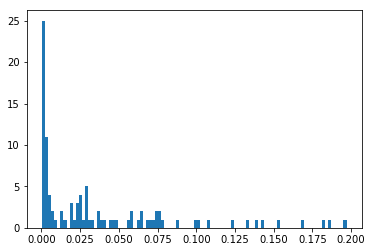

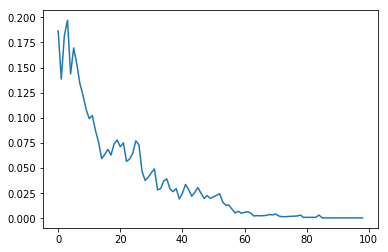

In [747]:
## VISUALIZE THE R DISTRUBTION ACROSSS ALL TIMESTEPS FOR AN EXCITATORY CELL

x = h_; # DESIGNATE CELL

# Plot pmf of timesteps R values
plt.figure(0)
plt.hist(x,100);

# Plot R(t) for all trials in a single concatenated array
plt.figure(1)
plt.plot(x)


In [763]:
# Replace all zero values in array
def replacezero (x):
    min_a = np.min([i for i in x if (i!=0.0)&(i!=np.nan)])
    for i_ind, i_x in enumerate(x):
        if i_x == 0.0:
            x[i_ind] = min_a/2
            
    return x

In [764]:
# PULL ZEROS FROM PMFs
y_ = replacezero(y_)
y1_ = replacezero(y1_)
z_ = replacezero(z_)
z1_ = replacezero(z1_)
m_ = replacezero(m_)
m1_ = replacezero(m1_)
h_ = replacezero(h_)
h1_ = replacezero(h1_)
yn_ = replacezero(yn_)
yn1_ = replacezero(yn1_)
zn_ = replacezero(zn_)
zn1_ = replacezero(zn1_)
mn_ = replacezero(mn_)
mn1_ = replacezero(mn1_)
hn_ = replacezero(hn_)
hn1_ = replacezero(hn1_)

In [442]:
## FUNCTION TO USE MLE TO FIT RESPONSE DISTS
    # Most of this function is incorporated from open source code:
        # https://stackoverflow.com/questions/42033893/producing-an-mle-for-a-pair-of-distributions-in-python
def choosedist(data):
    distributions = [sts.laplace, sts.norm, sts.t, sts.lognorm, sts.gumbel_r, sts.gumbel_l]
    mles = []

    for distribution in distributions:
        pars = distribution.fit(data)
        mle = distribution.nnlf(pars, data) # Retruns the negative log likelihood of the dist fit with the best fit parameters
        mles.append(mle)

    results = [(distribution.name, mle) for distribution, mle in zip(distributions, mles)]
    best_fit = sorted(zip(distributions, mles), key=lambda d: d[1])[0]
    print 'Best fit reached using {}, MLE value: {}'.format(best_fit[0].name, best_fit[1])

In [443]:
## FIT DIST FAMILY USING MLE
choosedist(free_2)
choosedist(free_4)
choosedist(free_6)
choosedist(free_8)
choosedist(noise_2)
choosedist(noise_4)
choosedist(noise_6)
choosedist(noise_8)

# ON AVERAGE THE LOGNORMAL: DISTRIBUTION SEEMS TO FIT THE RESPONSES THE BEST

Best fit reached using lognorm, MLE value: -222400.356358
Best fit reached using lognorm, MLE value: -1270.73571004
Best fit reached using lognorm, MLE value: 151247.668578
Best fit reached using lognorm, MLE value: 170197.04992
Best fit reached using lognorm, MLE value: -208597.964687
Best fit reached using lognorm, MLE value: 1541.82376092
Best fit reached using lognorm, MLE value: 180317.735501
Best fit reached using lognorm, MLE value: 162738.26152


In [489]:
## FUNCTION TO PLOT BEST FIT LOGNORM DIST FOR BOTH SUPRA AND SIG FOR ALL RESPONSE DISTRIBUTIONS
# Plot lognorm best fit params to outline distributions for visibility and comparision
# add a 'best fit' line
def fitlognorm(x):
    param = lognorm.fit(x); # fit the sample data
    x1 = np.linspace(np.min(x), np.max(x), np.size(x))
    pdf_fitted = lognorm.pdf(x1, param[0], loc=param[1], scale=param[2]) # fitted distribution
    return x1, pdf_fitted
    

In [765]:
## GET FITS TO PLOT FIGURE
a, afit = fitlognorm(free_2);
b, bfit = fitlognorm(free_4);
c, cfit = fitlognorm(free_6);
d, dfit = fitlognorm(free_8);

an, anfit = fitlognorm(noise_2);
bn, bnfit = fitlognorm(noise_4);
cn, cnfit = fitlognorm(noise_6);
dn, dnfit = fitlognorm(noise_8);

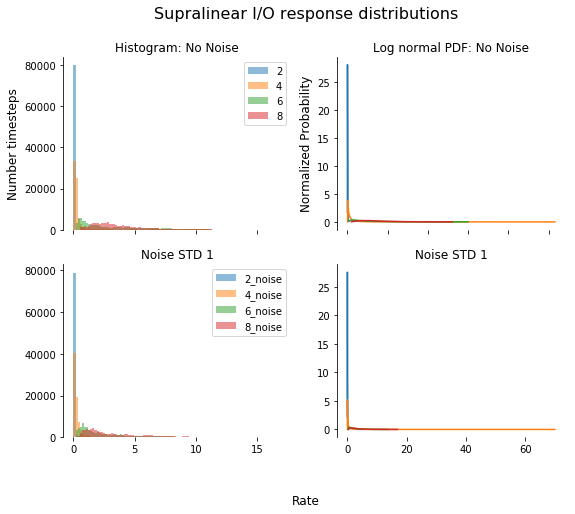

In [766]:
## CREATE FIGURE WITH FITTED RESPONSE DISTRIBUTIONS FOR R ACROSS INPUT LEVELS WITHIN NOISE CONDITION

# Create bins across the global firing rate range
bins = np.linspace(min1, max4, 100)

fig = plt.figure(figsize=(9,7))
fig.add_subplot(221)   #top left
fig.add_subplot(222)   #top right
fig.add_subplot(223)   #bottom left
fig.add_subplot(224)   #bottom right 

ax1 = plt.subplot(221)
ax1.hist(free_2, bins, alpha=0.5, label='2')
ax1.hist(free_4, bins, alpha=0.5, label='4')
ax1.hist(free_6, bins, alpha=0.5, label='6')
ax1.hist(free_8, bins, alpha=0.5, label='8')
ax1.legend(loc='upper right')    
ax1.set_title('Histogram: No Noise')
ax1.set_xticklabels([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('Number timesteps', fontsize=12)


ax3 = plt.subplot(223)
ax3.hist(noise_2, bins, alpha=0.5, label='2_noise')
ax3.hist(noise_4, bins, alpha=0.5, label='4_noise')
ax3.hist(noise_6, bins, alpha=0.5, label='6_noise')
ax3.hist(noise_8, bins, alpha=0.5, label='8_noise')
ax3.legend()
ax3.set_title('Noise STD 1')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

ax2 = plt.subplot(222)
ax2.plot(a, afit)
ax2.plot(b, bfit)
ax2.plot(c, cfit)
ax2.plot(d, dfit)
ax2.set_title('Log normal PDF: No Noise')
ax2.set_xticklabels([])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.legend()
# Steepness of h=2 response around zero Hz makes the plot zoom way out
    # Unhash the following to change range for sigmoidal functions
# ax2.set_xlim([0,10])
# ax2.set_ylim([0,4])
ax2.set_ylabel('Normalized Probability', fontsize=12)

ax4 = plt.subplot(224)
ax4.plot(an, anfit)
ax4.plot(bn, bnfit)
ax4.plot(cn, cnfit)
ax4.plot(dn, dnfit)
ax4.set_title('Noise STD 1')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.legend()
# Steepness of h=2 response around zero Hz makes the plot zoom way out
    # Unhash the following to change range for sigmoidal functions
# ax4.set_xlim([0,10]) 
# ax4.set_ylim([0,4])
    
# Common y axis title
fig.text(0.5, 0, 'Rate', va='center', rotation='horizontal', fontsize=12, ha = 'center')
    
# Global title
fig.suptitle('Supralinear I/O response distributions', fontsize=16)


In [306]:
## FUNCTION TO CALC KL
 # Most of this function is incorporated from open source code:
        # https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)#

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [733]:
## CALC KL DIVERGENCE FOR SUPRALINEAR I/O SSN ITERATION
klsup_f24 = KL(y_, y1_) # This calculates the KL divergence between the distribution of rate values across all timesteps of all trials
    # Above for h=2 and h=2 comparision with zero noise
klsup_f46 = KL(z_, z1_)
    # Above for h=4 and h=6 comparision with zero noise
klsup_f68 = KL(m_, m1_)
    # Above for h=6 and h=8 comparision with zero noise
klsup_f28 = KL(h_, h1_)
    # Above for h=2 and h=8 comparision with zero noise
klsup_n24 = KL(yn_, yn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input
klsup_n46 = KL(zn_, zn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input
klsup_n68 = KL(mn_, mn1_)
    # Above for h=6 and h=8 comparision with 1 STD white noise for h input
klsup_n28 = KL(hn_, hn1_)
    # Above for h=2 and h=8 comparision with 1 STD white noise for h input

print(klsup_f24)
print(klsup_f46)
print(klsup_f68)
print(klsup_f28)
print(klsup_n24)
print(klsup_n46)
print(klsup_n68)
print(klsup_n28)

0.430143771201
0.253266581524
0.273217738848
0.57114490725
0.521586755886
0.17313214329
0.317697829692
0.496827387875


In [842]:
## CALC KL DIVERGENCE FOR SATURATING I/O SSN INTERATION
klsig_f24 = KL(y_, y1_)
    # Above for h=2 and h=2 comparision with zero noise
klsig_f46 = KL(z_, z1_)
    # Above for h=4 and h=6 comparision with zero noise
klsig_f68 = KL(m_, m1_)
    # Above for h=6 and h=8 comparision with zero noise
klsig_f28 = KL(h_, h1_)
    # Above for h=2 and h=8 comparision with zero noise
klsig_n24 = KL(yn_, yn1_)
    # Above for h=2 and h=4 comparision with 1 STD white noise for h input
klsig_n46 = KL(zn_, zn1_)
    # Above for h=4 and h=6 comparision with 1 STD white noise for h input
klsig_n68 = KL(mn_, mn1_)
    # Above for h=6 and h=8 comparision with 1 STD white noise for h input
klsig_n28 = KL(hn_, hn1_)
    # Above for h=2 and h=8 comparision with 1 STD white noise for h input

print(klsig_f24)
print(klsig_f46)
print(klsig_f68)
print(klsig_f28)
print(klsig_n24)
print(klsig_n46)
print(klsig_n68)
print(klsig_n28)

602.14715994
28.9323646099
5.13705192831
1622.06536362
672.480416814
35.8032076304
2.44796853835
58.1886972168


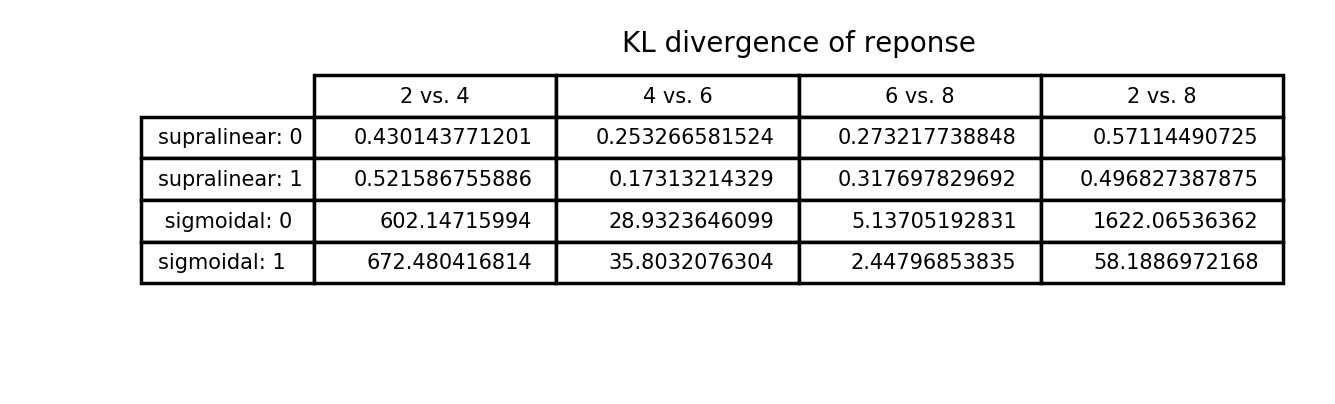

In [847]:
## KL Divergence Table
data = np.array([[klsup_f24, klsup_f46, klsup_f68, klsup_f28], [klsup_n24, klsup_n46, klsup_n68, klsup_n28],
                    [klsig_f24, klsig_f46, klsig_f68, klsig_f28], [klsig_n24, klsig_n46, klsig_n68, klsig_n28]])

colLabels=('2 vs. 4', '4 vs. 6', '6 vs. 8', '2 vs. 8')
rowLabels=('supralinear: 0', 'supralinear: 1', ' sigmoidal: 0', 'sigmoidal: 1')
nrows, ncols = len(data)+1, len(colLabels) + 1
hcell, wcell = 0.3, 1.
hpad, wpad = 0, 0    
fig=plt.figure('KL divergence of reponse', 
               figsize=(ncols*wcell+wpad, nrows*hcell+hpad), dpi=250)
plt.title('KL divergence of reponse', fontsize=8, y=.88)
ax = fig.add_subplot(111)
ax.axis('off')
table = ax.table(cellText=data,
          colLabels=colLabels, rowLabels=rowLabels, loc='center', fontsize=12)
# plt.savefig("table.png")